In [21]:
import pandas as pd
# 加载申购赎回表
df = pd.read_csv('user_balance_table.csv',parse_dates=['report_date'])
df

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,2014-08-25,550646,550585,61,0,0,0,0,0,0,0,0,61,NaN,NaN,NaN,NaN
2840417,28033,2014-08-31,525707,538147,60,0,0,0,12500,12500,0,0,0,60,0.0,0.0,0.0,12500.0
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,0,0,0,0,0,0,2297,NaN,NaN,NaN,NaN
2840419,28033,2014-07-27,20462288,20491722,2298,0,0,0,31732,0,31732,0,31732,2298,NaN,NaN,NaN,NaN


In [22]:
# purchase_amt redeem_amt

total_user_balance = df.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
total_user_balance

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587
...,...,...
2014-08-27,302194801,468164147
2014-08-28,245082751,297893861
2014-08-29,267554713,273756380


In [23]:
purchase = total_user_balance[['total_purchase_amt']]
redeem = total_user_balance[['total_redeem_amt']]
purchase

,total_purchase_amt
report_date,
2013-07-01,32488348
2013-07-02,29037390
2013-07-03,27270770
2013-07-04,18321185
2013-07-05,11648749
...,...
2014-08-27,302194801
2014-08-28,245082751
2014-08-29,267554713


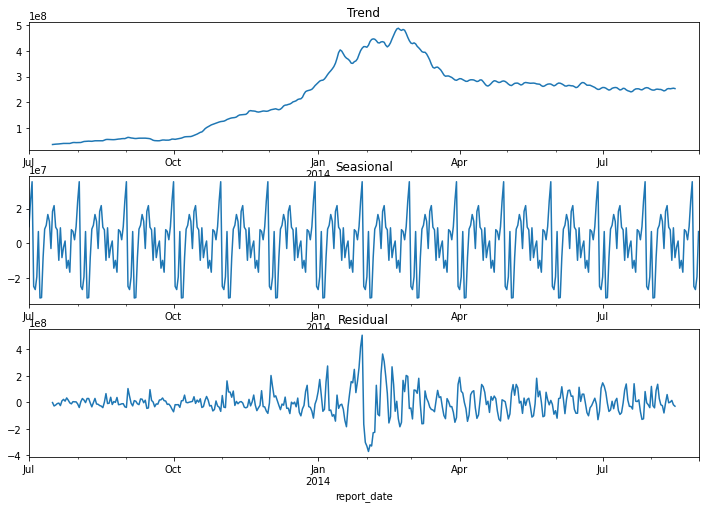

In [24]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 对制定范围内数据做可视化
def plot_stl(data):
  # 将数据分成 3个 component： trend seasional residual
  result = sm.tsa.seasonal_decompose(data,freq=30)
  # 可视化
  fig = plt.figure(figsize = (12,8))
  ax1 = fig.add_subplot(311)
  ax2 = fig.add_subplot(312)
  ax3 = fig.add_subplot(313)
  result.trend.plot(ax=ax1,title='Trend')
  result.seasonal.plot(ax=ax2,title='Seasional')
  result.resid.plot(ax=ax3,title='Residual')

plot_stl(purchase['total_purchase_amt'])


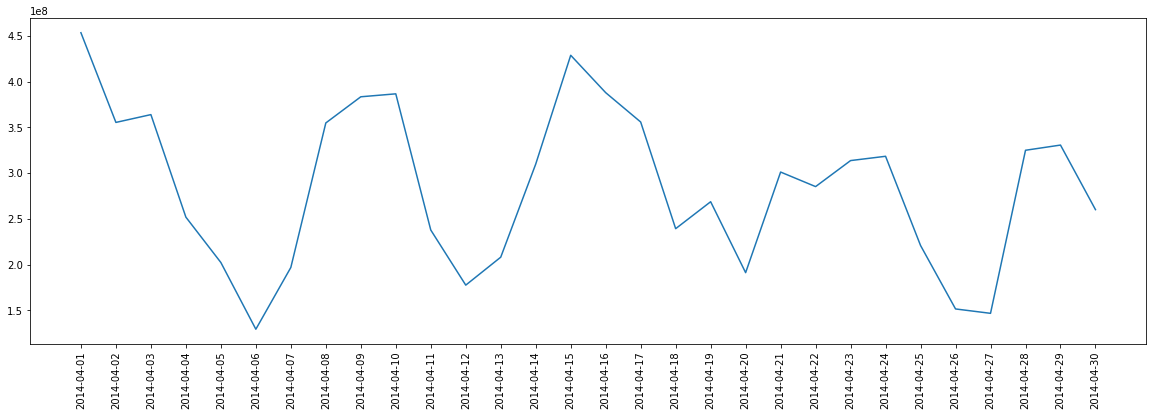

In [25]:
# chouqu 2014-04-01 到 2014-08-31
purchase2 = purchase[(purchase.index >= '2014-04-01') & (purchase.index <= '2014-04-30')]
purchase2
# 绘制4月份图
plt.figure(figsize=(20,6))
plt.plot(purchase2.total_purchase_amt)
date_range = pd.date_range('2014-04-01','2014-04-30')
plt.xticks(date_range,rotation=90)
plt.show()

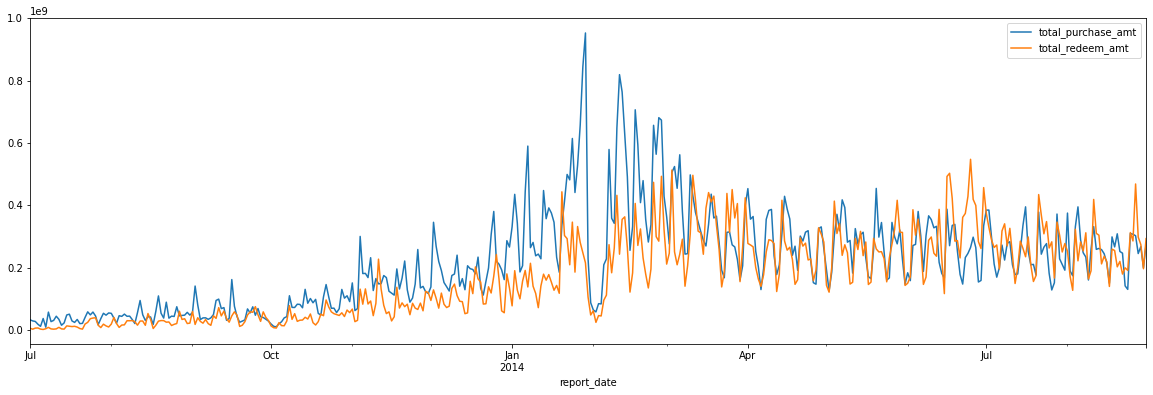

In [26]:
# 查看时间序列的平稳性
total_user_balance.plot(figsize=(20,6))
plt.show()

In [27]:
# ADF 检验
from statsmodels.tsa.stattools import adfuller
import numpy as np

np_purchase = purchase.to_numpy().reshape(-1)
t = adfuller(np_purchase)
t

(-1.5898802926313473,
 0.4886749751375944,
 18,
 408,
 {'1%': -3.446479704252724,
  '10%': -2.5705574627547096,
  '5%': -2.8686500930967354},
 15960.28197033403)

In [28]:
# 进行一阶差分
diff = 1
diff_purchase = purchase.diff(diff)
np_purchase = diff_purchase.to_numpy().reshape(-1)

t = adfuller(np_purchase[diff:])
t

(-7.947102224652351,
 3.1981868624880123e-12,
 18,
 407,
 {'1%': -3.4465195891135845,
  '10%': -2.5705668101226085,
  '5%': -2.8686676281678634},
 15918.844657651942)

In [29]:
t = adfuller(redeem.to_numpy().reshape(-1))
# 进行一阶差分
diff = 1
diff_redeem = redeem.diff(diff)
np_redeem = diff_redeem.to_numpy().reshape(-1)

t = adfuller(np_redeem[diff:])
t

(-11.691986906968792,
 1.6443717458501775e-21,
 12,
 413,
 {'1%': -3.4462831955497135,
  '10%': -2.5705114078759914,
  '5%': -2.8685636962704395},
 15779.04993673871)

In [30]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(purchase ,order=(7,1,5)).fit()
# 对购买进行预测
purchase_pred = model.predict('2014-09-01','2014-09-30',typ='levels')
model.aic

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


16669.64603396002

In [31]:

model = ARIMA(redeem ,order=(7,1,5)).fit()
# 对购买进行预测
redeem_pred = model.predict('2014-09-01','2014-09-30',typ='levels')
model.aic

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


16522.21868965174

In [32]:
result = pd.DataFrame()
result['report_date'] = purchase_pred.index
result['purchase'] = purchase_pred.values
result['redeem'] = redeem_pred.values
result

,report_date,purchase,redeem
0,2014-09-01,3.310540e+08,3.169072e+08
1,2014-09-02,3.318758e+08,3.372456e+08
2,2014-09-03,3.338904e+08,3.632422e+08
3,2014-09-04,2.983178e+08,3.074679e+08
4,2014-09-05,2.407506e+08,2.628007e+08
5,2014-09-06,2.266140e+08,2.258693e+08
6,2014-09-07,2.435559e+08,2.592133e+08
7,2014-09-08,2.970872e+08,3.115461e+08
8,2014-09-09,3.321271e+08,3.477430e+08
9,2014-09-10,3.265192e+08,3.562399e+08


In [33]:
result['report_date'] = result['report_date'].apply(lambda x:str(x).replace('-','')[:8])
# time
result
result.to_csv('tsa_base.csv',header=None,index=None)